## Micro Domain

The micro domain is defined by a bounding box and a smooth function parameterising the floor of the micro domain. 

In [3]:
import sys
sys.path.append('/home/emastr/phd/')

import torch
from boundary_solvers.gauss_grid_2d import *
import numpy as np
import matplotlib.pyplot as plt
from util.plot_tools import *
from boundary_solvers.blobs import *

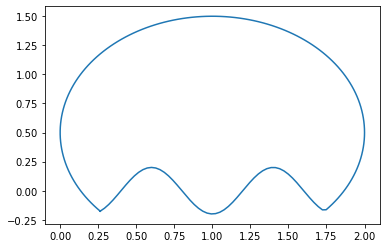

In [37]:
class MicroGeom(GaussLegGeometry):
    def __init__(self, func, dfunc, ddfunc, width, radius, y_center , line_pos, n_refine, n_corner_refine):
        
        center = y_center * 1j + width * 0.5
        
        #assert radius < np.abs(func(0)-center) and radius < np.abs(func(np.pi/2)-center), "radius too big!"
        #print(np.abs(func(0)-center))
        #print(np.abs(func(np.pi/2)-center))
        
        # parameterise func 
        f = lambda t: func(t)*1j + width * t / (np.pi/2)
        df = lambda t: dfunc(t)*1j + width / (np.pi/2)
        ddf = lambda t: ddfunc(t)*1j
        
        # Distance from center of circle
        r = lambda t: np.abs(f(t)-center)**2 - radius**2
        dr = lambda t: 2*np.real(df(t) * np.conjugate(f(t) - center)) 
        
        # Calculate intersections with circle
        t0 = self.interval_halving(r, 0, np.pi/4, 1e-12)#self.newton(r, dr, 0, 1e-12) # left corner
        t1 = self.interval_halving(r, np.pi/4, np.pi/2, 1e-12)#self.newton(r,dr, np.pi/2, 1e-12) # right corner
        a0, a1 = np.angle(f(t0)-center).squeeze(), np.angle(f(t1)-center).squeeze()
        
        # Reparameterise f to [0, a1]
        scale = (t1-t0)/(a1 - a0)
        g = lambda t: f(t0 + t * scale)
        dg = lambda t: df(t0 + t * scale)*scale
        ddg = lambda t: ddf(t0 + t * scale)*scale**2
        
        
        
        #print(f"a0:{a0}, a1:{a1}")
        dom = np.array([0, a1-a0, np.pi*2])
        c, dc, ddc = GaussLegGeometry.get_circle(radius, center, t0=0, t1=np.pi*2, a0=a0)
        z, dz, ddz = [g, c], [dg, dc], [ddg, ddc]
        
        #print(f"{np.angle(g(0))} vs {np.angle(c(0))}")
        
        # Stitch segments together
        z = GaussLegGeometry.stitch_functions_1d(z, dom)
        dz = GaussLegGeometry.stitch_functions_1d(dz, dom)
        ddz = GaussLegGeometry.stitch_functions_1d(ddz, dom)
        
        # Define grid
        grid = GaussLegGrid(dom, np.ones((3,)).astype(int))
        grid.refine_all_nply(n_refine)
        grid.refine_corners_nply(n_corner_refine)
        
        # Main properties
        self.width = width
        self.radius = radius
        self.line_pos = line_pos
        super().__init__([z, dz, ddz], grid)
    
    
    def get_inner_pt(self):
        """Overwrite inner_point to be independent of lower boundary."""
        return self.width/2 + self.line_pos * 1j
    
    def precompute_line_avg(self, derivative=0, **kwargs):
        return super().precompute_line_avg(0.05*2*np.radius + self.line_pos * 1j, 0.95*2*self.radius + self.line_pos*1j, derivative, **kwargs)
    
    def line_eval_adjoint(self, derivative=0, **kwargs):
        return super().line_eval_adjoint(0.05*2*np.radius + self.line_pos * 1j, 0.95*2*self.radius + self.line_pos*1j, derivative, **kwargs)
    
    
    @staticmethod
    def newton(f, df, x0, tol):
        x = x0
        res = tol + 1
        while np.abs(res) > tol:
            res = f(x)/df(x)
            x -= res
        return x
    
    @staticmethod
    def interval_halving(f, a, b, tol):
        res = tol+1
        f_a = f(a)
        f_b = f(b)
        #print(f"{f_a}, {f_b}")
        while np.abs(res) > tol:
            c = (a + b) / 2
            f_c = f(c)
            if f_a*f_c > 0:
                a = c
                f_a = f_c
            else:
                b = c
                f_b = f_c
            res = (b-a)
        return c
    
k=10
e = 0.2
f = lambda t: -e*np.sin(k*t)
df = lambda t: -e*np.cos(k*t) * k
ddf = lambda t: e*np.sin(k*t) * k**2
geom = MicroGeom(f, df, ddf, width=2, radius=1, y_center=0.5, line_pos=0., n_refine=1, n_corner_refine=2)
plt.figure()
geom.plot(plt.gca())

In [41]:
class GPDomain(MicroGeom):
    def __init__(self, kernel, shape, scale, num, bound=None, X=None, Y=None, K_inv_dy=None, **kwargs):
        
        self.k, self.dk, self.ddk = self.get_kernel(kernel, scale, shape)
        width = kwargs["width"]
        
        if (X is None):
            X, Y, K_inv_dy = self.sample_bounded_gp(self.k, width, bound, num)
            
        r = width / (0.5 * np.pi)
        y = lambda t: K_inv_dy.T @ self.k(r*t, X)
        dy = lambda t: K_inv_dy.T @ self.dk(r*t, X)*r
        ddy = lambda t: K_inv_dy.T @ self.ddk(r*t, X)*r**2
        
        # Data that is used in function methods.
        self.X = X
        self.Y = Y
        
        # Hidden data
        self.kwargs = kwargs
        self.data = {"kernel": kernel,
                     "shape": shape,
                     "scale": scale,
                     "num": num,
                     "Y": Y,
                     "X": X,
                     "K_inv_dy": K_inv_dy}
        super().__init__(y, dy, ddy, **kwargs)
    
    def save(self, path):
        data = self.data.copy()
        data.update(self.kwargs)
        torch.save(data, path)
    
    def plot(self, show_samples=True, show_hline=True, **kwargs):
        super().plot(**kwargs)
        color = kwargs.pop("color", "black")
        ax = kwargs.pop("ax")
        if show_hline:
            ax.plot([0.05*self.radius*2, 0.95*self.radius*2],[self.line_pos, self.line_pos], linewidth=4, color=color)
        if show_samples:
            ax.scatter(self.X, self.Y)
            #plt.scatter(self.X, self.K_inv_df)
    
    @staticmethod
    def load(path, **kwargs):
        if type(path) == str:
            data = torch.load(path)
        elif type(path) == dict:
            data = path
        gp_dom = GPDomain(**data)
        return gp_dom
    
    @staticmethod
    def get_kernel(name, scale, shape):
        if name == "exp":
            # Do smth else
            k = lambda x, y: scale * np.exp(-((x - y) ** 2) / shape)
            dk = lambda x, y: - 2 / shape * (x - y) * k(x, y)
            ddk = lambda x, y: - 2 / shape * (1 - 2 / shape * (x - y)**2) * k(x, y)
        else:
            assert False,f"Kernel {name} not implemented"
        return k, dk, ddk
    
    @staticmethod
    def sample_bounded_gp(k, width, bound, num, resample=0):
            X = np.linspace(-0.1*width, 1.1*width, num)[:,None]#np.sort(np.random.uniform(-0.1*width, 1.1*width, num))[:,None]
            K = k(X, X.T)
            Y = np.random.multivariate_normal(np.zeros_like(X).flatten(), K)[:, None]
            K_inv_dy = np.linalg.solve(K, Y)
            
            #print(K_inv_dy)
            if np.max(np.abs(Y)) >= bound:
                print(f"Resample # {resample}", end="\r")
                return GPDomain.sample_bounded_gp(k, width, bound, num, resample+1)
            else:
                return X, Y, K_inv_dy
            

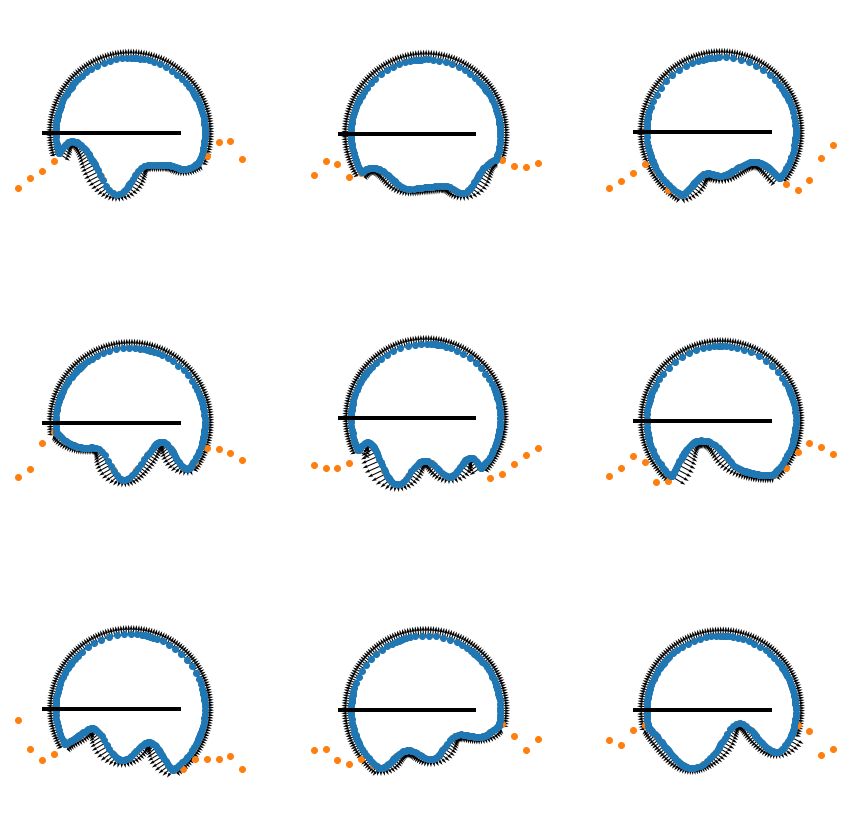

In [42]:
np.random.seed(0)
n = 3
plt.figure(figsize=(15,15))
riesz = []
zvec = []
for i in range(n * n):
    
    mg = GPDomain("exp", 
                  shape=.1, 
                  num=20, 
                  scale=.08, 
                  bound=.4, 
                  width=2.5,
                  y_center=0.5,
                  radius=1,
                  line_pos=0.5, 
                  n_refine=0, 
                  n_corner_refine=3)    
    
    ### PLOT ###
    print(f"{i+1}/{n*n} done", end="\r")
    plt.subplot(n,n,i+1) 
    mg.plot(ax=plt.gca(), showpts=True, shownormals=True)
    remove_axes(plt.gca())
    plt.axis("equal")
    
#plt.figure()
#for r in riesz:
#    plt.plot(np.imag(r))

Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations


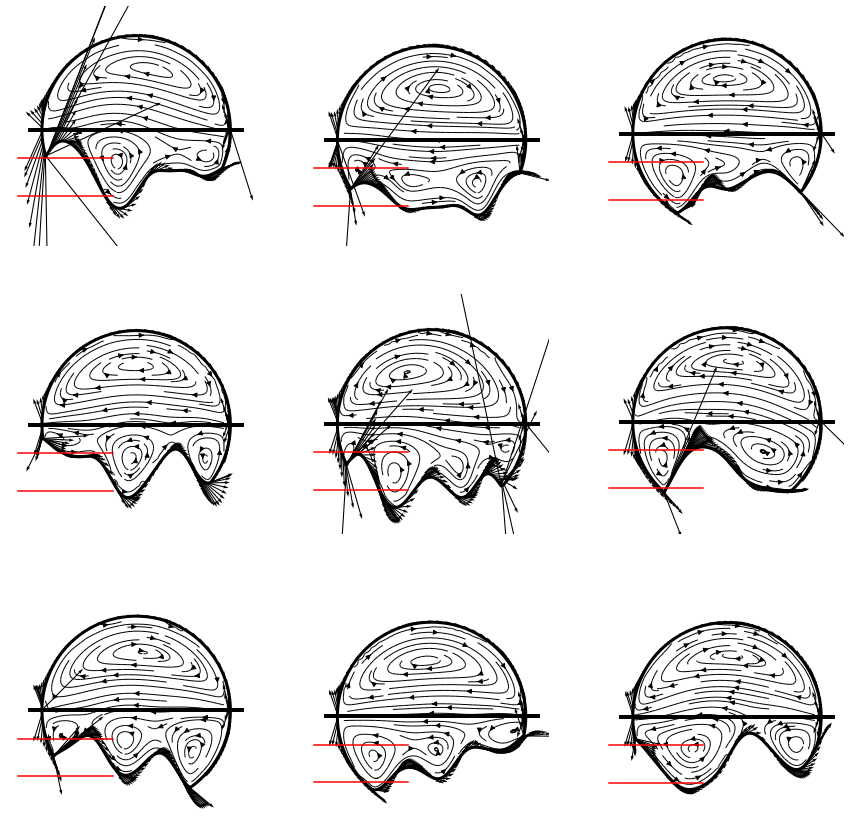

In [34]:
np.random.seed(0)
n = 3
plt.figure(figsize=(15,15))
riesz = []
zvec = []
for i in range(n * n):
    
    mg = GPDomain("exp", 
                  shape=.1, 
                  num=20, 
                  scale=.08, 
                  bound=.4, 
                  width=2.5,
                  y_center=0.5,
                  radius=1,
                  line_pos=0.5, 
                  n_refine=0, 
                  n_corner_refine=3)       
    
    r1, func = mg.precompute_line_avg(derivative=0, tol=1e-10, maxiter=400, verbose=True)
    r2, _    = mg.precompute_line_avg(derivative=1, tol=1e-10, maxiter=400, verbose=True)
    mg.data["riesz_vec"]     = r1
    mg.data["riesz_vec_der"] = r2
    z = mg.eval_param()
    
    # To test, plot field corresponding to riesz vector
    v = mg.zero_flow(r1)
    v /= np.linalg.norm(v)
    condition = lambda t: v
    problem = StokesDirichletProblem(mg, condition)
    problem.solve(tol=1e-9, maxiter=40)
    
    ### PLOT ###
    print(f"{i+1}/{n*n} done", end="\r")
    plt.subplot(n,n,i+1) 
    
    vel = lambda z: np.abs(problem.evaluate(z))
    #problem.geometry.plot_field(ax=plt.gca(), func=vel, apply_mask=True, cmap='inferno', vmax=np.max(np.abs(v)))
    #problem.geometry.plot_stream(ax=plt.gca(), func=problem.evaluate, apply_mask=True, color='white')
    #plt.quiver(np.real(z), np.imag(z), np.real(r1), np.imag(r1), color="red", scale=5)
    #mg.plot(ax=plt.gca(), show_samples=False, color="white", linewidth=3)  
    
    problem.geometry.plot_stream(ax=plt.gca(), func=problem.evaluate, apply_mask=True, color='black', linewidth=1)
    plt.quiver(np.real(z), np.imag(z), np.real(r1), np.imag(r1), color="black", scale=8)
    mg.plot(ax=plt.gca(), show_samples=False, color="black", linewidth=3)  
    
    plt.plot([0,1], [0.2,0.2], "red")
    plt.plot([0,1], [-0.2,-0.2], "red")
    
    #plt.axis("equal")
    #plt.xlim([-0.1, 1.1])
    #plt.ylim([-1.0, 1.2])
    remove_axes(plt.gca())
    plt.axis("equal")
    
    riesz.append(r1)
    zvec.append(z)
    
#plt.figure()
#for r in riesz:
#    plt.plot(np.imag(r))

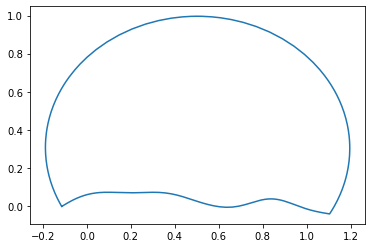

In [7]:
z_mean = np.zeros_like(zvec[0])
for z in zvec:
    z_mean += z / n**2

plt.plot(np.real(z_mean), np.imag(z_mean))

In [ ]:
np.random.seed(0)
N = 2000
plt.figure(figsize=(15,15))
riesz = []
zvec = []
for i in range(N):
    print(f"{i+1}/{N} done", end="\n")
    mg = GPDomain("exp", 
                  shape=.05, 
                  num=20, 
                  scale=.03, 
                  bound=.3, 
                  width=1,
                  y_center=0.3,
                  radius=0.7,
                  line_pos=0.4, 
                  n_refine=0, 
                  n_corner_refine=4)  
    
    r1, func = mg.precompute_line_avg(derivative=0, tol=1e-12, maxiter=200, verbose=True)
    r2, _    = mg.precompute_line_avg(derivative=1, tol=1e-12, maxiter=200, verbose=True)
    r11, _    = mg.line_eval_adjoint(derivative=0, tol=1e-12, maxiter=200, verbose=True)
    r12, _    = mg.line_eval_adjoint(derivative=1, tol=1e-12, maxiter=200, verbose=True)
    
    vec = np.conjugate(mg.eval_param())
    a = mg.line_pos * 1j + 0.05 * mg.width
    b = mg.line_pos * 1j + 0.95 * mg.width
    print(f"numerical: {func(vec)}, true: {np.real(b**2 - a**2)/2}")
    
    mg.data["riesz_vec"]     = r1
    mg.data["riesz_vec_der"] = r2
    mg.data["line_eval_adj"] = r11
    mg.data["line_eval_adj_der"] = r12
    
    mg.save(f"/home/emastr/phd/data/micro_domains_w_riesz_vectors_circular/domain_{i}.GPDomain")
    
    

1/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500005838368241, true: 0.44999999999999996
2/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999223230835883, true: 0.44999999999999996
3/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499999838835067, true: 0.44999999999999996
4/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500001363134113, true: 0.44999999999999996
5/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500004329918812, true: 0.44999999999999996
6/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500601625484116, true: 0.44999999999999996
7/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45000429278211995, true: 0.44999999999999996
8/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45003261466989264, true: 0.44999999999999996
9/2000 done
Converged in 0 it

/home/emastr/phd/boundary_solvers/gauss_grid_2d.py:466: RuntimeWarning: divide by zero encountered in true_divide
  integrand[m] = np.imag(dparam[m] / (param[m] - param[n])) * weights[n] / np.pi
/home/emastr/phd/boundary_solvers/gauss_grid_2d.py:471: RuntimeWarning: invalid value encountered in true_divide
  integrand_conj[m] = -np.imag(dparam[m] * np.conjugate(param[m] - param[n])) / \


Converged in 200 iterations
numerical: nan, true: 0.44999999999999996
11/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45000045064249183, true: 0.44999999999999996
12/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499999204674777, true: 0.44999999999999996
13/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44974351105068244, true: 0.44999999999999996
14/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44997045872922437, true: 0.44999999999999996
15/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499941870456839, true: 0.44999999999999996
16/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500542129567214, true: 0.44999999999999996
17/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45000760847233895, true: 0.44999999999999996
18/2000 done
Converged in 0 iterations
Converged in 0 iterations
numeric

Converged in 0 iterations
numerical: 0.45004868645090734, true: 0.44999999999999996
79/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999986626445554, true: 0.44999999999999996
80/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45000229896737176, true: 0.44999999999999996
81/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45003014854294043, true: 0.44999999999999996
82/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44994835725020943, true: 0.44999999999999996
83/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500731608899256, true: 0.44999999999999996
84/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4501700723137694, true: 0.44999999999999996
85/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500004237221392, true: 0.44999999999999996
86/2000 done
